In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import numpy as np
import datetime
import gc

In [4]:
plt.style.use("dark_background")

In [5]:
from utils import sql_table_to_pandas, str2iter_match_ratio
from plotting import (
    plot_countplot,
    plot_aggregated_barplot,
    plot_lineplot,
    plot_normalised_barplot,
    plot_distplot
)

In [6]:
pd.set_option(
    'display.max_rows', 100,
    'display.max_columns', None,
    'display.max_colwidth', 200,
    'display.width', 100,
    'display.float_format', '{:4,.2f}'.format
)


## Dataset description

- *status*: investigation status
- *time*: the time of accident
- *day*: the day of accident
- *month*: the monthe of accident
- *year*: the year of accdient
- *first_flight*: the year of aircraft first flight
- *total_airframe_hrs*: the hours that aircraft flied
- *aircraft_type*: the model of aircraft
- *operator*: the company, organisation or individual operating the aircraft at the time of the accident
- *country*: the country of accident
- *location*: more detailed location of accident
- *phase*: the phase of flight
- *nature*: the nature of the flight
- *engines*: number and type (model and mark) of engines
- *narrative*: the description of the occurrence
- *probable_cause*: the probable cause of the accident as established by the accident investigators
- *aircraft_damage*: describes the amount of damage to the airplane as a result of the occurrence
- *departure_airport*: the last airport of departure before the accident
- *destination_airport*: the scheduled destination airport
- *crew_occupants*: the exact number of flight- and cabincrew members aboard the aircraft at the time of departure
- *crew_fatalities*: the number of crew members who fatally injured as a direct result of the accident
- *passengers_occupants*: the number of passengers aboard the aircraft at the time of departure
- *passengers_fatalities*: the number of passengers who fatally injured as a direct result of the accident
- *total_occupants*: crew_occupants + passengers_occupants
- *total_fatalities*: crew_fatalities + passengers_fatalities

## Dataset cleaning

In [144]:
df = sql_table_to_pandas('../db_config.JSON', 'accidents')

In [192]:
df_aircraft = sql_table_to_pandas('../db_config.JSON', 'aircraft')
# df_aircraft.columns = [c if 'aircraft' in c else f'aircraft_{c}' for c in df_aircraft.columns]
# df = pd.merge(df_accidents, df_aircraft, how='left', on='aircraft_type')

In [146]:
df = df[(df['year'] > 1919) & (df['year'] < 2020) & pd.notna(df['year'])] # selecting only full years

In [147]:
df = df.replace({None: np.nan, 'None': np.nan})

In [148]:
df.shape

(22693, 28)

###### time

In [149]:
def get_time_range(x) -> str or np.nan:
    if pd.isnull(x):
        return np.nan

    if x < datetime.time(4, 0):
        return '00:00 - 03:59'
    elif x < datetime.time(8, 0):
        return '04:00 - 07:59'
    elif x < datetime.time(12, 0):
        return '08:00 - 11:59'
    elif x < datetime.time(16, 0):
        return '12:00 - 15:59'
    elif x < datetime.time(20, 0):
        return '16:00 - 19:59'
    else:
        return '20:00 - 23:59'

In [150]:
df['time'] = df['time'].apply(lambda x: np.nan if pd.isnull(x) else str(x)[-8:])
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time
df['time_range'] = df['time'].apply(get_time_range)
df.drop(columns=['time'], inplace=True)

In [151]:
df['time_range'].value_counts()

12:00 - 15:59    1924
08:00 - 11:59    1885
16:00 - 19:59    1741
20:00 - 23:59    1115
04:00 - 07:59     889
00:00 - 03:59     565
Name: time_range, dtype: int64

###### weekday

In [152]:
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['weekday'] = pd.Categorical(df['weekday'], categories=cats, ordered=True)

In [153]:
df['weekday'].value_counts()

Friday       3499
Thursday     3342
Tuesday      3289
Wednesday    3285
Monday       3142
Saturday     3027
Sunday       2599
Name: weekday, dtype: int64

###### day

No correction

In [154]:
df['day'].value_counts()

10.00    888
24.00    787
15.00    778
27.00    764
19.00    760
23.00    750
6.00     748
13.00    742
18.00    741
17.00    739
4.00     737
11.00    736
12.00    736
22.00    735
28.00    732
9.00     731
14.00    723
26.00    720
7.00     719
21.00    708
25.00    707
2.00     703
16.00    702
8.00     694
5.00     677
30.00    677
3.00     672
20.00    668
1.00     658
29.00    652
31.00    399
Name: day, dtype: int64

###### month

No correction

In [155]:
df['month'].value_counts()

12.00    2000
1.00     1997
3.00     1994
9.00     1986
5.00     1950
7.00     1872
8.00     1832
6.00     1831
11.00    1828
4.00     1788
10.00    1738
2.00     1633
Name: month, dtype: int64

###### year

In [156]:
df['year'] = df['year'].astype(int)
df['decade'] = (df['year'] // 10 * 10).apply(lambda x: f'{x}s')

In [157]:
df['decade'].value_counts()

1940s    5698
1970s    2780
1960s    2536
1990s    2508
1950s    2328
1980s    2267
2000s    2154
2010s    1973
1930s     376
1920s      73
Name: decade, dtype: int64

###### first_flight

In [158]:
def get_age_range(age) -> str or np.nan:
    if pd.isnull(age):
        return np.nan
    
    if age < 1:
        return '0 - 1'
    elif age < 3:
        return '1 - 3'
    elif age < 5:
        return '3 - 5'
    elif age < 10:
        return '5 - 10'
    elif age < 20:
        return '10 - 20'
    elif age < 30:
        return '20 - 30'
    elif age < 50:
        return '30 - 50'
    else:
        return '> 50'

In [159]:
df['aircraft_age'] = (df['year'] - df['first_flight']).apply(lambda x: np.nan if x < 0 or np.isnan(x) else x)
df['aircraft_age_range'] = df['aircraft_age'].apply(get_age_range)
df.drop(columns=['first_flight'], inplace=True)

In [160]:
df['aircraft_age_range'].value_counts()

10 - 20    3765
1 - 3      3233
5 - 10     2776
20 - 30    2607
30 - 50    1810
0 - 1      1480
3 - 5      1367
> 50        223
Name: aircraft_age_range, dtype: int64

###### total_airframe_hrs

No correction

In [161]:
df['total_airframe_hrs'].dtype

dtype('float64')

###### aircraft_damage

In [162]:
df['aircraft_damage'].replace({'Missing': 'Unknown'}, inplace = True)

In [163]:
df['aircraft_damage'].value_counts()

Damaged beyond repair    15847
Substantial               2918
Destroyed                 2203
Unknown                    811
Minor                      268
Name: aircraft_damage, dtype: int64

###### phase

In [164]:
df['phase'].value_counts()

En route (ENR)             5475
Unknown                    4831
Landing (LDG)              4347
Approach (APR)             2556
Takeoff (TOF)              1979
Standing (STD)             1569
Initial climb (ICL)        1077
Taxi (TXI)                  430
Maneuvering (MNV)           363
Pushback / towing (PBT)      66
Name: phase, dtype: int64

###### country

In [165]:
df['country'].value_counts()

United States of America    4069
Russia                      1255
Unknown                      854
United Kingdom               819
Canada                       773
                            ... 
Macau                          1
East Timor                     1
Eswatini                       1
Tuvalu                         1
Cook Islands                   1
Name: country, Length: 231, dtype: int64

###### nature

In [166]:
def get_nature_group(x) -> str:
    if x in ('Military', 'Unknown', 'Test', 'Cargo', 'Private', 'Official state flight', ):
        return x
    elif x in ('Executive', 'Training', ):
        return 'Training / Executive'
    elif 'Passenger' in x:
        return 'Passenger'
    elif x in ('Agricultural',  'Survey/research', 'Aerial Work (Calibration, Photo)'):
        return 'Scientific'
    else:
        return 'Other'

In [167]:
df['nature_group'] = df['nature'].apply(get_nature_group)

In [168]:
df['nature_group'].value_counts()

Military                 8155
Passenger                6751
Unknown                  3020
Cargo                    1986
Other                    1136
Training / Executive      886
Scientific                295
Test                      227
Private                   197
Official state flight      40
Name: nature_group, dtype: int64

## Data Analysis

### Timely Analysis

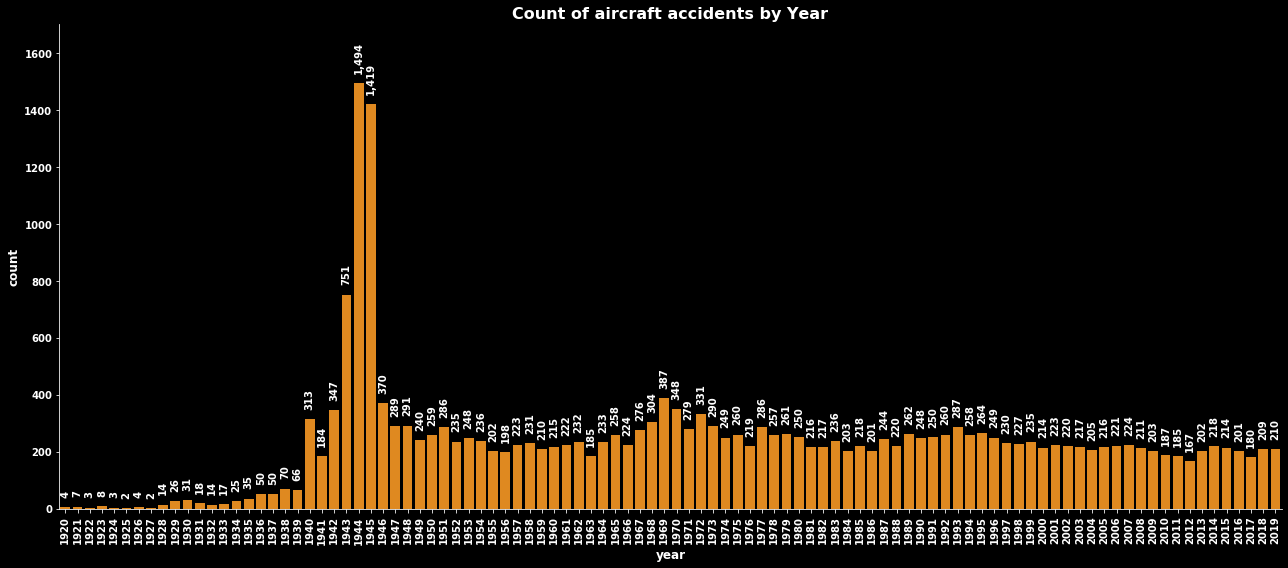

In [169]:
plot_countplot(
    df, 
    'year', 
    hue_column=None, 
    figsize=(18, 8), 
    title='Count of aircraft accidents by Year',
    ylims=(0, 1700)
)

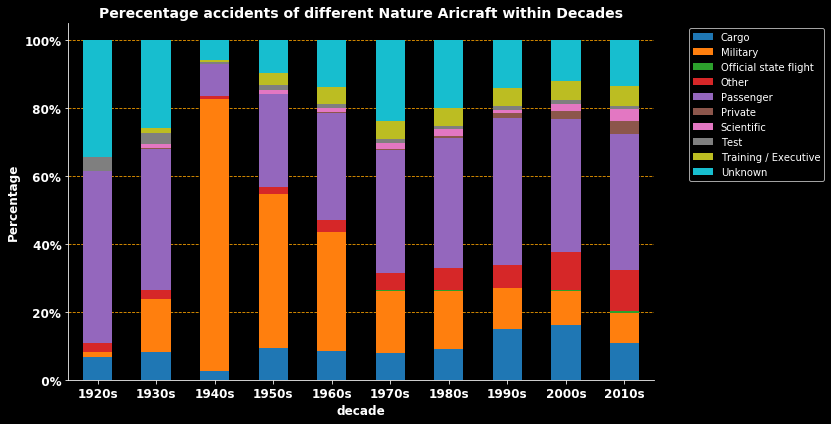

In [170]:
temp = df.groupby(by=['decade'])['nature_group'].apply(
    lambda x: x.value_counts() / len(x)).unstack()

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
plt.title(
    'Perecentage accidents of different Nature Aricraft within Decades',
    fontsize=14, fontweight='bold'
)
temp.plot(ax=ax, kind='bar', stacked=True, rot=0,
          color=sns.color_palette('tab10', n_colors=10))
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x * 100) for x in vals])
ax.set_axisbelow(True)
sns.despine()
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.xlabel('decade', fontsize=12, fontweight='bold')
plt.ylabel('Percentage', fontsize=12, fontweight='bold')

plt.grid(True, axis='y', linestyle='--', color='orange')
plt.tight_layout()

plt.show()

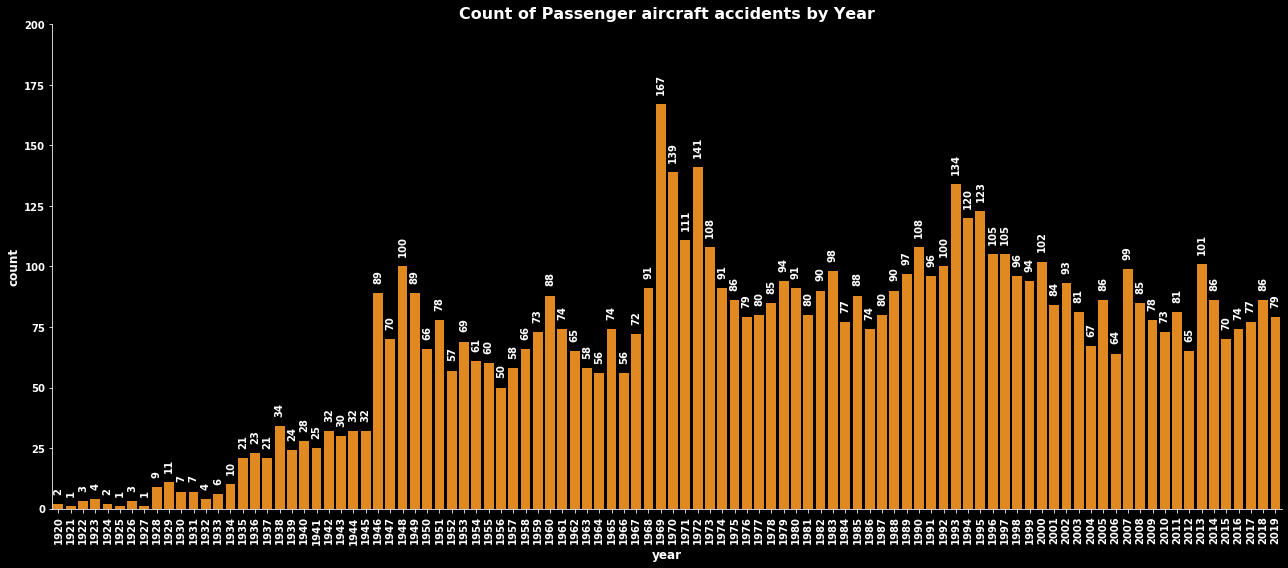

In [171]:
plot_countplot(
    df[df['nature_group'] == 'Passenger'], 
    'year', 
    figsize=(18, 8), 
    title='Count of Passenger aircraft accidents by Year',
    ylims=(0, 200)
)

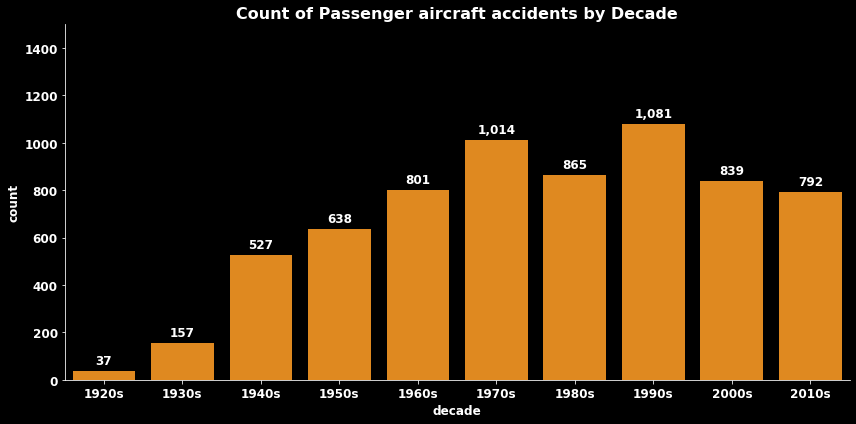

In [172]:
plot_countplot(
    df[df['nature_group'] == 'Passenger'].sort_values(by='decade'), 
    'decade', 
    figsize=(12, 6), 
    title='Count of Passenger aircraft accidents by Decade',
    ylims=(0, 1500),
    ticks_rotation=0,
    ticks_fontsize=12
)

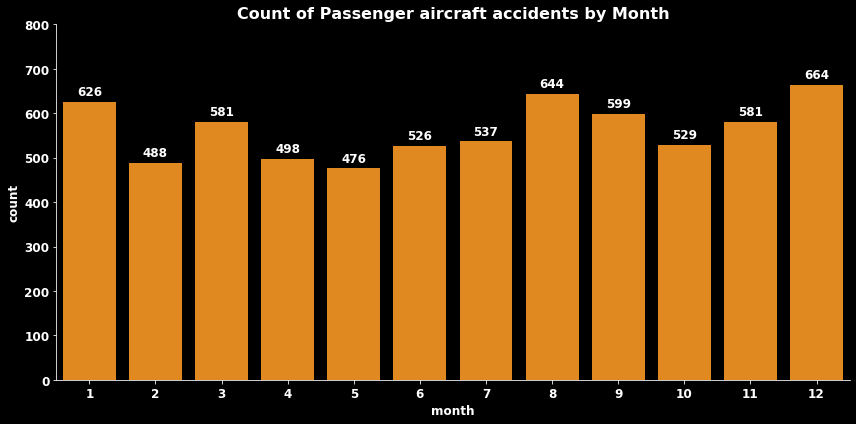

In [173]:
temp = df[df['nature_group'] == 'Passenger']
temp = temp[pd.notna(temp['month'])]
temp['month'] = temp['month'].astype(int)
plot_countplot(
    temp, 
    'month', 
    figsize=(12, 6), 
    title='Count of Passenger aircraft accidents by Month',
    ylims=(0, 800),
    ticks_rotation=0,
    ticks_fontsize=12
)

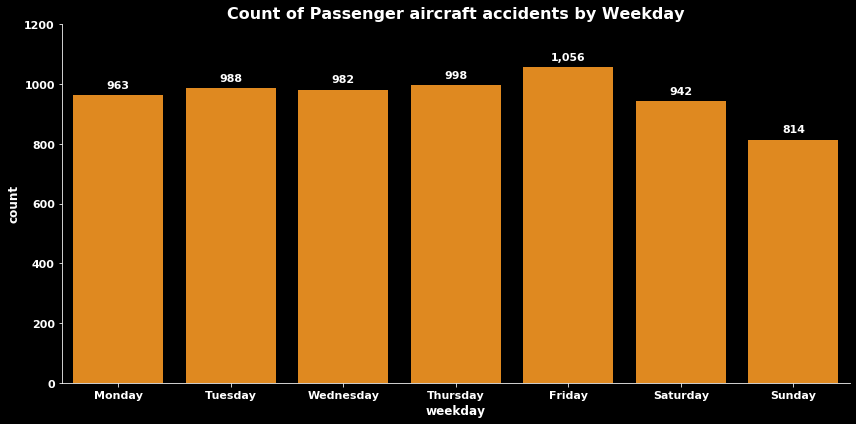

In [174]:
plot_countplot(
    df[df['nature_group'] == 'Passenger'].sort_values(by='weekday'), 
    'weekday', 
    figsize=(12, 6), 
    title='Count of Passenger aircraft accidents by Weekday',
    ylims=(0, 1200),
    ticks_rotation=0,
    ticks_fontsize=11
)

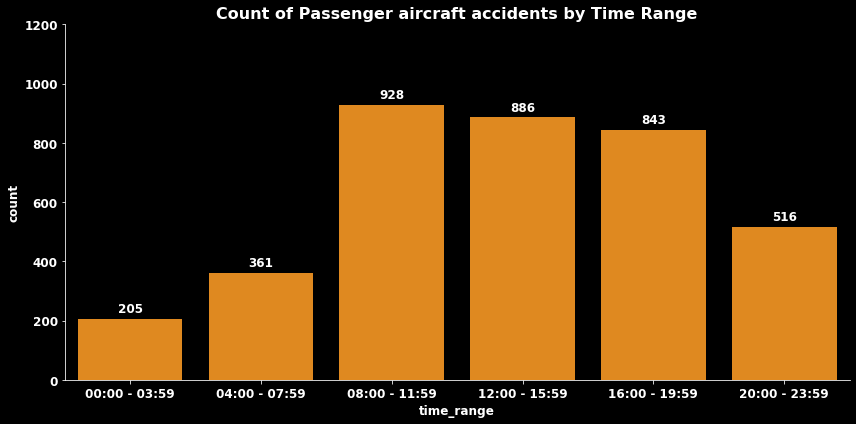

In [175]:
plot_countplot(
    df[df['nature_group'] == 'Passenger'].sort_values(by='time_range'), 
    'time_range', 
    figsize=(12, 6), 
    title='Count of Passenger aircraft accidents by Time Range',
    ylims=(0, 1200),
    ticks_rotation=0,
    ticks_fontsize=12
)

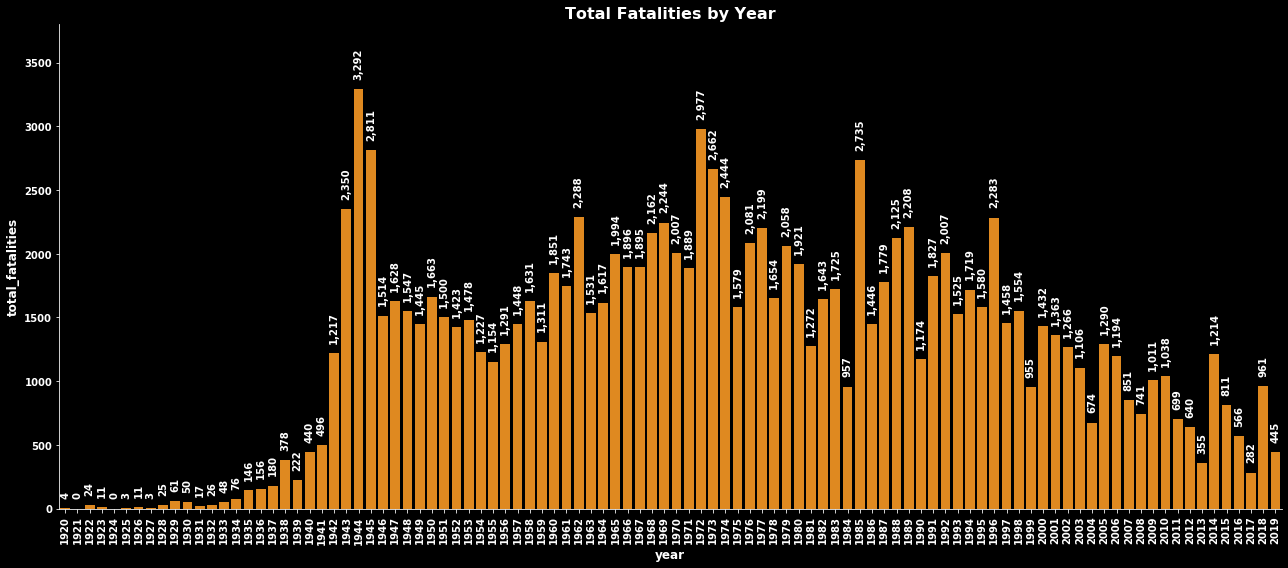

In [176]:
plot_aggregated_barplot(
    df,
    'year',
    'total_fatalities',
    'sum',
    figsize=(18, 8),
    title='Total Fatalities by Year',
    ylims=(0, 3800)
)

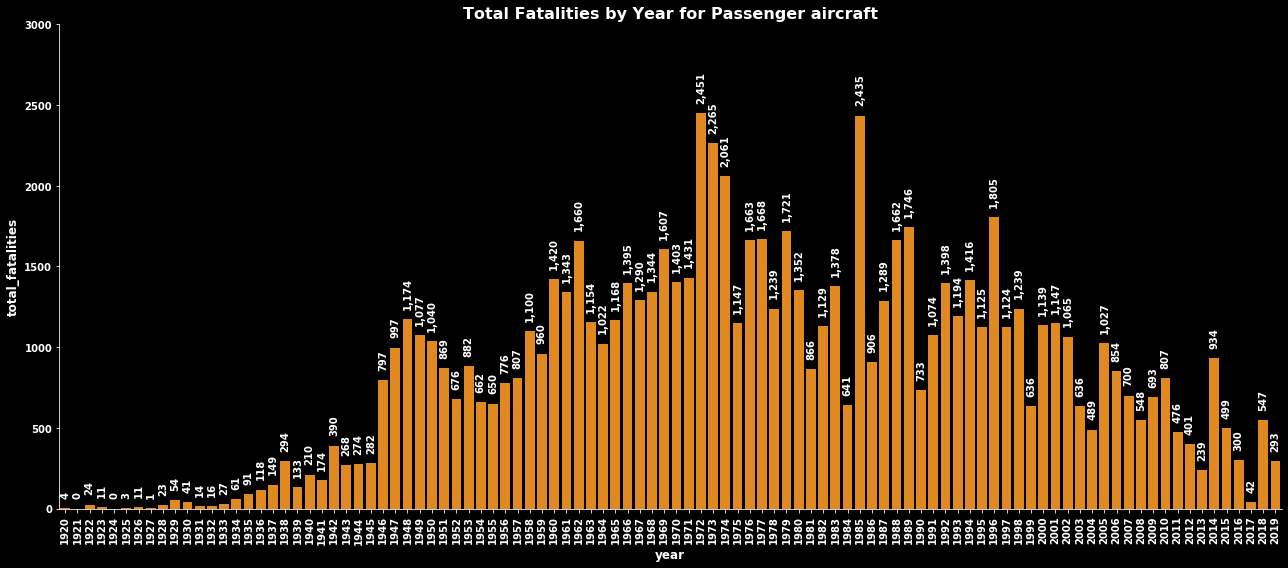

In [177]:
plot_aggregated_barplot(
    df[df['nature_group'] == 'Passenger'],
    'year',
    'total_fatalities',
    'sum',
    figsize=(18, 8),
    title='Total Fatalities by Year for Passenger aircraft',
    ylims=(0, 3000)
)

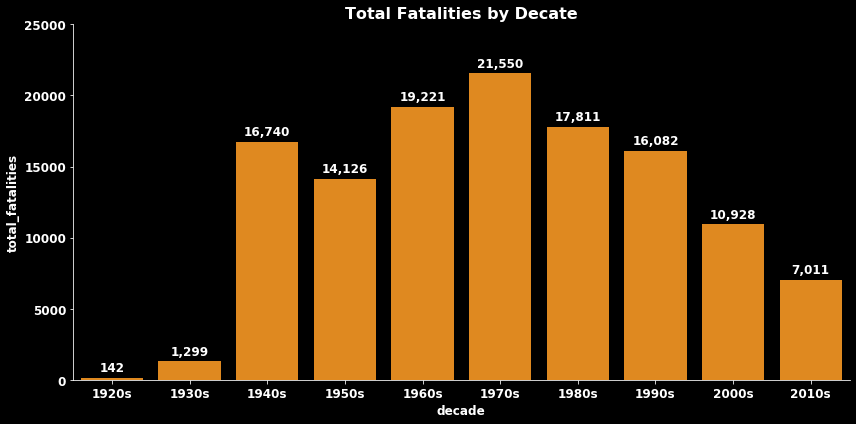

In [178]:
plot_aggregated_barplot(
    df,
    'decade',
    'total_fatalities',
    'sum',
    figsize=(12, 6),
    title='Total Fatalities by Decate',
    ylims=(0, 25000),
    ticks_rotation=0,
    ticks_fontsize=12
)

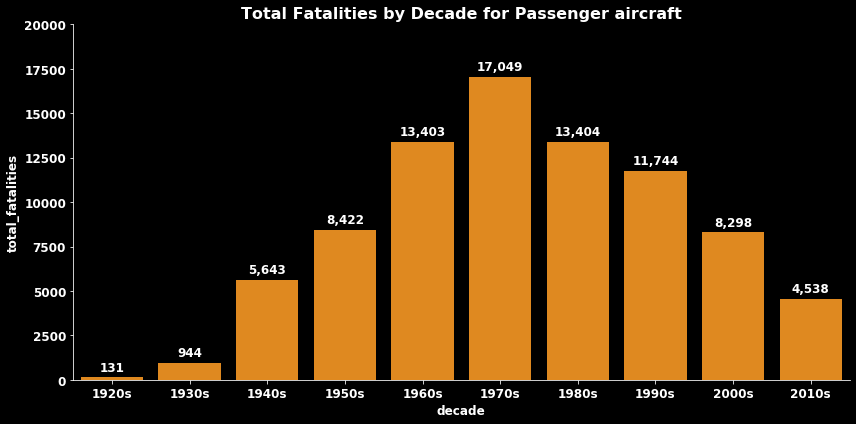

In [179]:
plot_aggregated_barplot(
    df[df['nature_group'] == 'Passenger'],
    'decade',
    'total_fatalities',
    'sum',
    figsize=(12, 6),
    title='Total Fatalities by Decade for Passenger aircraft',
    ylims=(0, 20000),
    ticks_rotation=0,
    ticks_fontsize=12
)

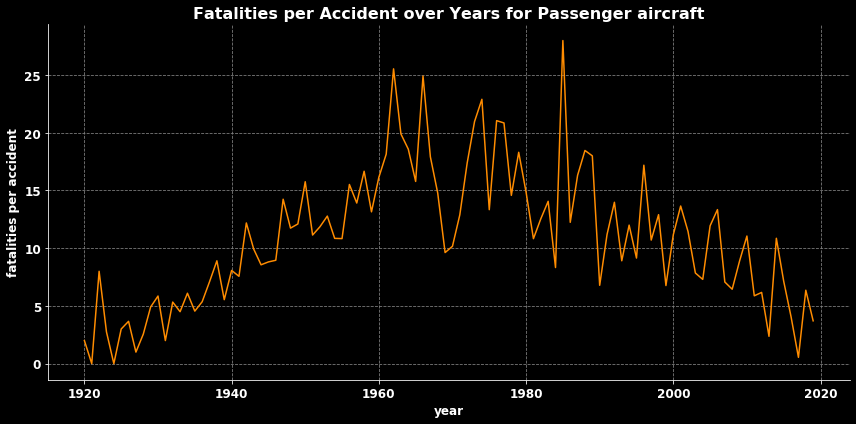

In [180]:
temp = df[df['nature_group'] == 'Passenger']
temp = temp[pd.notna(temp['total_fatalities'])].groupby('year').agg({'total_fatalities': ('sum', 'count')})
temp.columns = ['_'.join(col).strip() for col in temp.columns]
temp = temp.reset_index()
temp['fatalities per accident'] = temp['total_fatalities_sum'] / temp['total_fatalities_count']
plot_lineplot(
    temp,
    'year',
    'fatalities per accident',
    figsize=(12, 6),
    title='Fatalities per Accident over Years for Passenger aircraft',
    ticks_rotation=0,
    ticks_fontsize=12
    
)

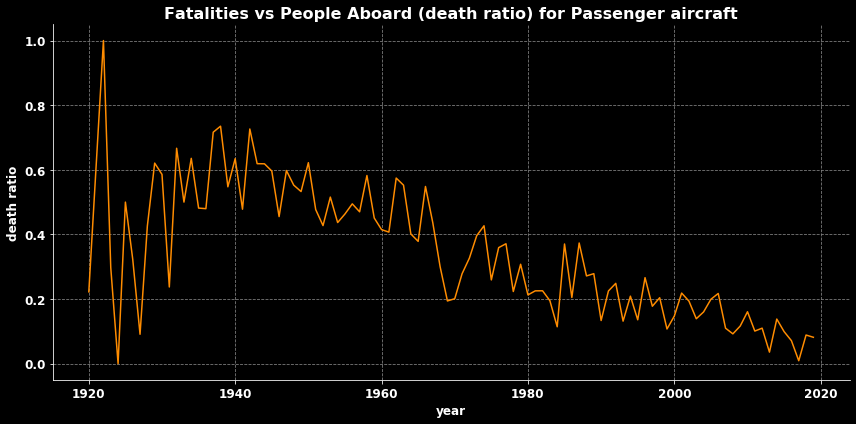

In [181]:
temp = df[df['nature_group'] == 'Passenger']
temp = temp[pd.notna(temp['total_fatalities'])].groupby('year').agg(
    {'total_fatalities': 'sum', 'total_occupants': 'sum'}
)
temp = temp.reset_index()
temp['death ratio'] = temp['total_fatalities'] / temp['total_occupants']
plot_lineplot(
    temp,
    'year',
    'death ratio',
    figsize=(12, 6),
    title='Fatalities vs People Aboard (death ratio) for Passenger aircraft',
    ticks_rotation=0,
    ticks_fontsize=12
)

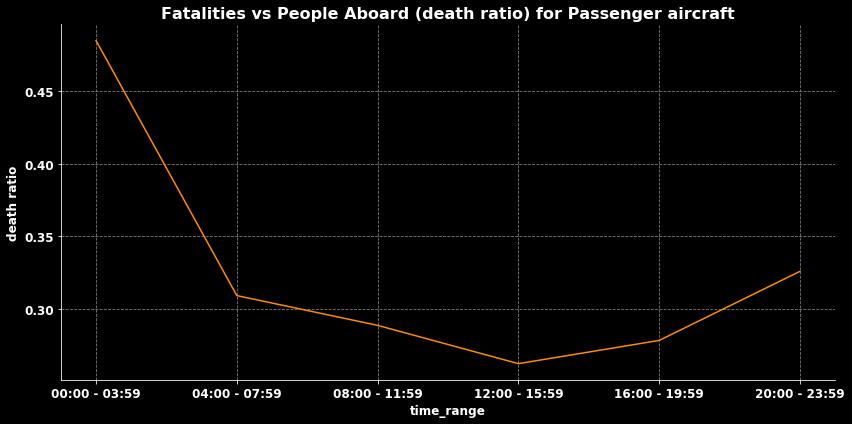

In [182]:
temp = df[df['nature_group'] == 'Passenger']
temp = temp[pd.notna(temp['total_fatalities'])].groupby('time_range').agg(
    {'total_fatalities': 'sum', 'total_occupants': 'sum'}
)
temp = temp.reset_index()
temp['death ratio'] = temp['total_fatalities'] / temp['total_occupants']
plot_lineplot(
    temp,
    'time_range',
    'death ratio',
    figsize=(12, 6),
    title='Fatalities vs People Aboard (death ratio) for Passenger aircraft',
    ticks_rotation=0,
    ticks_fontsize=12
)

The first two plot shows air crash count in each year and fatality count and death ratio in each ten years. We can see that after 1970, total amount of accidents and people die from accidents are both decreasing. Due to lack of annually flights count data, we can't simply say that accident rate is decreasing. However, the death rate went down from over 90% to around 65% throughout history, which means passengers are more likely to survive than before in an air crash.
The third plot shows air crash death ratio by time of day. Number of air crash are distinguished by day and night. Again, due to data limitation, we can't conclude that at what time it has higher accident rate, but death rate during night is higher than during day.

In [191]:
df['aircraft_type'].head()

3          Lockheed 18-56-23 Lodestar
4          Douglas C-47A-30-DK (DC-3)
5                     Ilyushin Il-18A
6                      Boeing 707-436
7    Scottish Aviation Twin Pioneer 1
Name: aircraft_type, dtype: object

In [86]:
import re

In [87]:
list(map(int, re.findall(r'\d+', 'Fatalities: 1600')))

[1600]